Task 2d, CNN on permutated MNIST Dataset, PR Course 2020
===
Team "chaussette"

In [1]:
from PIL import Image
import glob
import torch.utils.data as data
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt

## Data loading and datasets creation

In [2]:
def read_data(root_dir):
    files = glob.glob(root_dir+'/[0-9]/*.png')

    images=[]
    labels=[]

    for file in tqdm(files):
        with Image.open(file) as temp:
            temp = Image.open(file).convert("RGB")
            keep = temp.copy()
            # sometimes the file path had some '\' instead of only '/' (maybe only for windows)
            labels.append(int(file.replace('\\', '/').split('/')[-2]))
            images.append(keep)
            
    return images, labels

In [3]:
class MNISTDataset(data.Dataset):
    
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
    
        return len(self.images)

    def __getitem__(self, idx):

        label = self.labels[idx]
        image = self.images[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [4]:
from torchvision.transforms import ToTensor, Normalize, Compose

validation_size = 0.3
root_dir = '../data/mnist-permutated-png-format'

train_dir= root_dir + '/train'
test_dir= root_dir + '/test'
val_dir = root_dir + '/val'

# read the png files of MNIST
X_train, y_train = read_data(train_dir)
X_test, y_test = read_data(test_dir)
X_val, y_val = read_data(val_dir)

In [5]:
transform = Compose([ToTensor(), # Converts to Tensor, scales to [0, 1] float (from [0, 255] int)
                    Normalize(mean=(0.5, 0.5, 0.5,), std=(0.5, 0.5, 0.5)), # scales to [-1.0, 1.0]
                    ])
train_set = MNISTDataset(X_train, y_train, transform=transform)
val_set = MNISTDataset(X_val, y_val, transform=transform)
test_set = MNISTDataset(X_test, y_test, transform=transform)

print(f"Length of training set : {len(train_set)}")
print(f"Length of validation set : {len(val_set)}")
print(f"Length of test set : {len(test_set)}")

Length of training set : 40200
Length of validation set : 19800
Length of test set : 10000


## CNN architecture

In [9]:
import torch.nn as nn


class Flatten(nn.Module):
    """
    Flatten a convolution block into a simple vector.

    Replaces the flattening line (view) often found into forward() methods of networks. This makes it
    easier to navigate the network with introspection
    """
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x


class PR_CNN(nn.Module):
    """
    Simple feed forward convolutional neural network

    Attributes
    ----------
    expected_input_size : tuple(int,int)
        Expected input size (width, height)
    conv1 : torch.nn.Sequential
    conv2 : torch.nn.Sequential
    conv3 : torch.nn.Sequential
        Convolutional layers of the network
    fc : torch.nn.Linear
        Final classification fully connected layer

    """

    def __init__(self, **kwargs):
        """
        Creates an CNN_basic model from the scratch.

        Parameters
        ----------
        output_channels : int
            Number of neurons in the last layer
        input_channels : int
            Dimensionality of the input, typically 3 for RGB
        """
        super(PR_CNN, self).__init__()

        # PR_FILL_HERE: Here you have to put the expected input size in terms of width and height of your input image
        self.expected_input_size = (28, 28)

        # First layer
        self.conv = nn.Sequential(
            # PR_FILL_HERE: Here you have to put the input channels, output channels ands the kernel size
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=3),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=3),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=3),
            nn.LeakyReLU()
        )


        # Classification layer
        self.fc = nn.Sequential(
            Flatten(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        """
        Computes forward pass on the network

        Parameters
        ----------
        x : Variable
            Sample to run forward pass on. (input to the model)

        Returns
        -------
        Variable
            Activations of the fully connected layer
        """
        x = self.conv(x)
        x = self.fc(x)
        return x


## CNN training

In [7]:
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import trange, tqdm
import numpy as np

def train_epoch(model, train_dataloader, optimizer, loss_fn):
    losses = []
    correct_predictions = 0
    model.train()
    # Iterate mini batches over training dataset
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        # Run predictions
        output = model(images)
        # Set gradients to zero
        optimizer.zero_grad()
        # Compute loss
        loss = loss_fn(output, labels)
        # Backpropagate (compute gradients)
        loss.backward()
        # Make an optimization step (update parameters)
        optimizer.step()
        # Log metrics
        losses.append(loss.item())
        predicted_labels = output.argmax(dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()
    # Return loss values for each iteration and accuracy
    mean_loss = np.array(losses).mean()
    accuracy = 100.0 * correct_predictions / len(train_dataloader.dataset)
    return mean_loss, accuracy

def evaluate(model, dataloader, loss_fn):
    losses = []
    correct_predictions = 0
    # Iterate mini batches over validation dataset
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            # Run predictions
            output = model(images)
            # Compute loss
            loss = loss_fn(output, labels)
            # Save metrics
            losses.append(loss.item())
            predicted_labels = output.argmax(dim=1)
            correct_predictions += (predicted_labels == labels).sum().item()
    # Return mean loss and accuracy
    mean_loss = np.array(losses).mean()
    accuracy = 100.0 * correct_predictions / len(dataloader.dataset)
    return mean_loss, accuracy

def train(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_function):
    # We will monitor loss functions as the training progresses
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Run training for n_epochs
    for epoch in trange(n_epochs):

        train_loss, train_accuracy = train_epoch(model, train_dataloader, optimizer, loss_fn)
        val_loss, val_accuracy = evaluate(model, val_dataloader, loss_fn)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        """print('Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                      train_losses[-1],
                                                                                                      train_accuracies[-1],
                                                                                                      val_losses[-1],
                                                                                                      val_accuracies[-1]))"""
    return train_losses, val_losses, train_accuracies, val_accuracies


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# setup parameters
n_epochs = 20
num_workers = 0
loss_fn = nn.CrossEntropyLoss()

batch_size = 32

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers,pin_memory=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

learning_rates=[0.001,0.01,0.1]

models={}
optimizers={}

# create the models 
for learning_rate in learning_rates:
    models[learning_rate]= PR_CNN()
    models[learning_rate] = models[learning_rate].to(device)
    optimizers[learning_rate]= torch.optim.Adam(models[learning_rate].parameters(), lr=learning_rate)

train_losses={}
val_losses={}
train_acc={}
val_acc={}

best_model, best_val_acc, best_lr = None, -1, -1

# train and evaluate the models
for learning_rate in tqdm(learning_rates):
    print(f'\nTraining model with lr = {learning_rate}')
    train_losses_i, val_losses_i, train_acc_i, val_acc_i = train(models[learning_rate], 
                                                                 train_dataloader, val_dataloader, 
                                                                 optimizers[learning_rate], n_epochs=n_epochs, 
                                                                 loss_function=loss_fn)
    train_losses[learning_rate]=train_losses_i
    val_losses[learning_rate]=val_losses_i
    train_acc[learning_rate]=train_acc_i
    val_acc[learning_rate]=val_acc_i
    
    print(f"Accuracy on validation : {val_acc_i[-1]:.2f} %")
    
    if val_acc_i[-1] > best_val_acc:
        best_model = models[learning_rate]
        best_val_acc = val_acc_i[-1]
        best_lr = learning_rate
    
print(f"Best model found's accuracy on validation : {best_val_acc:.2f} %, with learning rate : {best_lr}")


Training model with lr = 0.001



Accuracy on validation : 96.85 %

Training model with lr = 0.01



Accuracy on validation : 93.96 %

Training model with lr = 0.1



Accuracy on validation : 49.92 %

Best model found's accuracy on validation : 96.85 %, with learning rate : 0.001


### Results

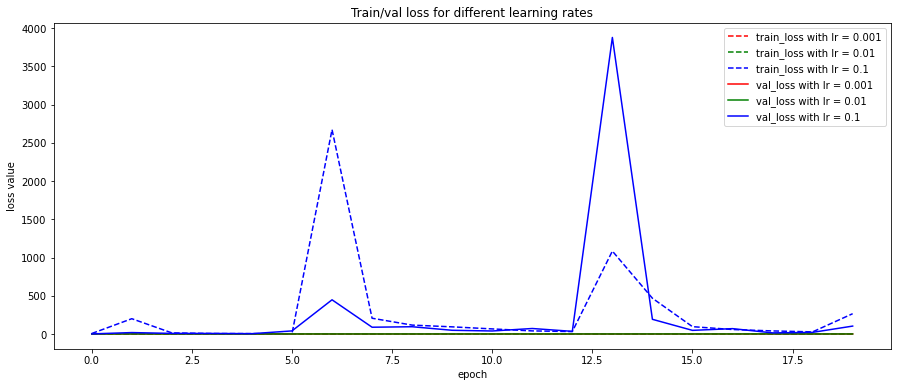

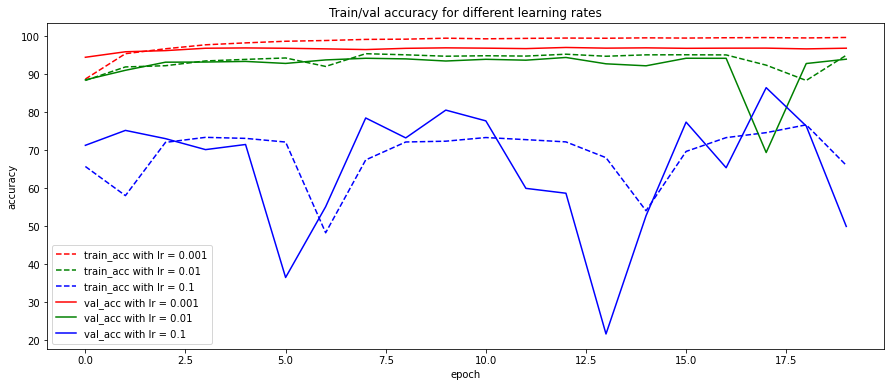

In [20]:
def plot(n_epochs, train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(15,6))
    
    legend_loss=[]
    
    colors=['r','g','b']
    
    i=0
    for learning_rate,train_loss in train_losses.items():
        plt.plot(np.arange(n_epochs), train_loss,f'{colors[i]}--')
        legend_loss.append(f'train_loss with lr = {learning_rate}')
        i+=1
        
    i=0
    for learning_rate,val_loss in val_losses.items():
        plt.plot(np.arange(n_epochs), val_loss,colors[i])
        legend_loss.append(f'val_loss with lr = {learning_rate}')
        i+=1
        
    plt.legend(legend_loss)
    
    plt.xlabel('epoch')
    plt.ylabel('loss value')
    plt.title('Train/val loss for different learning rates');

    plt.figure(figsize=(15,6))
    
    legend_acc=[]
    
    i=0
    for learning_rate,train_acc in train_accuracies.items():
        plt.plot(np.arange(n_epochs), train_acc,f'{colors[i]}--')
        legend_acc.append(f'train_acc with lr = {learning_rate}')
        i+=1
        
    i=0
    for learning_rate,val_acc in val_accuracies.items():
        plt.plot(np.arange(n_epochs), val_acc,colors[i])
        legend_acc.append(f'val_acc with lr = {learning_rate}')
        i+=1
    
    plt.legend(legend_acc)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Train/val accuracy for different learning rates');

plot(n_epochs, train_losses, val_losses, train_acc, val_acc)


## Evaluation on the test set

In [18]:
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers,pin_memory=True)
                    
test_loss, test_accuracy = evaluate(best_model, test_dataloader, loss_fn=loss_fn)

print(f"Accuracy on the test set : {test_accuracy} %")

Accuracy on the test set : 95.91 %
